# README

This notebook uses the following libraries:
- `numpy`
- `pandas`
- `sklearn`
- `matplotlib`

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Built into ipython
from IPython.display import HTML, display

# Built into python
from collections import Counter

# Part 1

In [2]:
# dataset: [X, y]
dataset = sklearn.datasets.load_iris(return_X_y=True)

# Extract feature labels for Part 4
features = list(sklearn.datasets.load_iris(return_X_y=True, as_frame=True)[0].columns)

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
dataset = (scaler.fit_transform(*dataset), dataset[1])

# Split data
TRAIN_SPLIT = 0.8
train_X, test_X, train_y, test_y = sklearn.model_selection.train_test_split(
    *dataset,
    train_size=TRAIN_SPLIT, test_size=1 - TRAIN_SPLIT,
    stratify=dataset[1],
    random_state=15
)

# Print input shape and target class distribution
print(f"X shape: {"x".join(map(str, dataset[0].shape))}")
print(f"y distribution:\n{"\n".join([f"\t{k}: {v / len(dataset[1]) * 100:.2f}%" for k, v in Counter(dataset[1]).items()])}")

# Functions to handle each problem
classes = np.array([c for c in set(dataset[1])])
def convert_y(y, c):
    return (y[:] == c).astype(np.int8)
def logits_to_class(logits):
    axis = 1 - len(logits.shape)
    mask = logits >= 0.5
    return np.where(np.any(mask, axis=axis), np.argmax(mask, axis=axis), -1)

X shape: 150x4
y distribution:
	0: 33.33%
	1: 33.33%
	2: 33.33%


# Part 2

Weights:
	Class 0: [-1.64572848  2.83971484 -2.03175472 -2.70907358]
	Class 1: [ 0.06381215 -1.09863875  1.08202742 -1.19808358]
	Class 2: [-0.45072096  0.78729592  0.92538118  1.95422353]
Final Loss:
	Total: -117.14475217664845
	Per-class: [ -3.89212267 -68.10912079 -45.14350873]
Loss curves


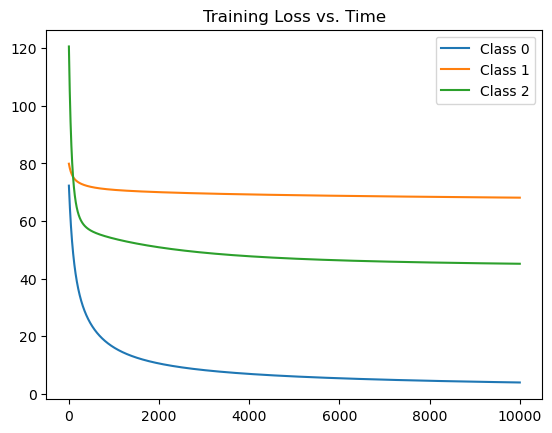

Predicted:
[1 0 2 1 1 1 1 0 2 1 0 1 0 1 1 0 0 1 1 2 0 1 1 0 1 1 2 2 1 1 2 2 1 1 2 0 0
 0 0 1 1 2 1 2 0 0 0 0 1 1 0 0 0 1 1 2 1 0 1 2 2 0 0 1 0 0 0 1 2 0 0 2 1 1
 2 0 0 0 2 0 1 1 1 1 1 1 1 0 1 1 1 2 2 1 1 0 1 0 1 2 1 1 0 1 0 1 0 2 1 1 2
 2 2 0 0 1 1 2 0 1]
Actual:
[1 0 2 1 1 1 2 0 2 1 0 1 0 2 1 0 0 1 2 2 0 2 1 0 2 1 2 2 2 2 2 2 2 2 2 0 0
 0 0 1 1 2 1 2 0 0 0 0 1 1 0 0 0 1 2 1 1 0 2 2 2 0 0 1 0 0 0 1 1 0 0 2 1 2
 1 0 0 0 1 0 1 2 1 2 1 1 1 0 2 1 2 1 2 2 1 0 1 0 2 2 1 1 0 2 0 2 0 1 1 1 2
 2 2 0 0 1 2 2 0 1]
Accuracy:
	Overall: 77.50%
	Per-class:
		Class 0: 100.00%
		Class 1: 70.00%
		Class 2: 76.67%


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lr_model(X, w):
    return sigmoid(X @ w.T)

def lr_loss(X, y, w):
    y_hat = lr_model(X, w)
    return np.sum((y[:] * np.log(y_hat[:])) + ((1 - y[:]) * np.log(1 - y_hat[:])))

def lr_loss_grad(X, y, w):
    y_hat = lr_model(X, w)
    return (y - y_hat) @ X

def logistic_regression(X, y, learning_rate=0.0001, num_iterations=10_000):
    w = np.random.normal(size=X.shape[1])
    loss = np.ndarray(shape=num_iterations)
    for i in range(num_iterations):
        loss[i] = lr_loss(X, y, w)
        w += learning_rate * lr_loss_grad(X, y, w)
    return {
        "weights": w,
        "loss": loss,
    }

def multi_class_logistic_regression(X, y, **kwargs):
    results = [
        logistic_regression(X, convert_y(y, c), **kwargs)
        for c in classes
    ]
    return {
        "weights": np.stack([r["weights"] for r in results]),
        "loss": np.stack([r["loss"] for r in results]).T,
    }

def get_accuracy(X, y, weights):
    logits = lr_model(X, weights)
    predicted = logits_to_class(logits)
    per_class = []
    for i, c in enumerate(classes):
        class_y = convert_y(y, c)
        per_class.append(sum(p == a for p, a in zip(logits.T[c] >= 0.5, class_y)) / len(class_y))
    return {
        "predicted": predicted,
        "overall": sum(p == a for p, a in zip(predicted, y)) / len(predicted),
        "per_class": np.array(per_class)
    }

def print_accuracy(X, y, weights):
    acc = get_accuracy(X, y, weights)
    print("Predicted:")
    print(acc["predicted"])
    print("Actual:")
    print(y)
    print("Accuracy:")
    print(f"\tOverall: {acc["overall"] * 100:.2f}%")
    print("\tPer-class:")
    for c, a in zip(classes, acc["per_class"]):
        print(f"\t\tClass {c}: {a * 100:.2f}%")

model = multi_class_logistic_regression(train_X, train_y)

print("Weights:")
print("\n".join(f"\tClass {c}: {model["weights"][i]}" for i, c in enumerate(classes)))
print("Final Loss:")
print(f"\tTotal: {sum(model["loss"][-1])}")
print(f"\tPer-class: {model["loss"][-1]}")
print("Loss curves")
plt.title("Training Loss vs. Time")
plt.plot(model["loss"] * -1)
plt.legend([f"Class {c}" for c in classes])
plt.show()

print_accuracy(train_X, train_y, model["weights"])

del model

# Part 3

In [4]:
def get_top_k_features(weights, k):
    return [
        features[i]
        for i, _ in sorted(
            enumerate(weights),
            key=lambda t: t[1],
            reverse=True
        )[:k]
    ]

weights_no_reg = np.stack([
    sklearn.linear_model.LogisticRegression(penalty=None)
        .fit(train_X, convert_y(train_y, c))
        .coef_[0]
    for c in classes
])

print("Weights:")
for i, c  in enumerate(classes):
    print(f"\tClass {c}: {weights_no_reg[i]}")

print()
print("Top 3 features:")
for i, c in enumerate(classes):
    print(f"\tClass {c}: {", ".join(get_top_k_features(weights_no_reg[i], 3))}")

print()
print_accuracy(train_X, train_y, weights_no_reg)

print()
confusion = sklearn.metrics.confusion_matrix(test_y, logits_to_class(lr_model(test_X, weights_no_reg)))
print("Confusion Matrix:")
print(confusion)
del confusion

Weights:
	Class 0: [-1.9533204   2.91955752 -6.43249944 -5.32207779]
	Class 1: [-0.64884866 -0.9812195   3.59730859 -2.90076526]
	Class 2: [ -5.62437423 -26.06602412  90.21342948 157.21832397]

Top 3 features:
	Class 0: sepal width (cm), sepal length (cm), petal width (cm)
	Class 1: petal length (cm), sepal length (cm), sepal width (cm)
	Class 2: petal width (cm), petal length (cm), sepal length (cm)

Predicted:
[1 0 2 1 1 1 1 0 2 1 0 1 0 1 1 0 0 1 1 2 0 1 1 0 1 1 2 2 1 1 2 2 1 1 2 0 0
 0 0 1 1 2 1 2 0 0 0 0 1 1 0 0 0 2 1 2 1 0 1 2 2 0 0 1 0 0 0 1 2 0 0 2 1 1
 2 0 0 0 2 0 1 1 1 1 1 1 1 0 1 1 1 2 2 1 1 0 2 0 1 2 1 1 0 1 0 1 0 2 1 1 2
 2 2 0 0 1 1 2 0 1]
Actual:
[1 0 2 1 1 1 2 0 2 1 0 1 0 2 1 0 0 1 2 2 0 2 1 0 2 1 2 2 2 2 2 2 2 2 2 0 0
 0 0 1 1 2 1 2 0 0 0 0 1 1 0 0 0 1 2 1 1 0 2 2 2 0 0 1 0 0 0 1 1 0 0 2 1 2
 1 0 0 0 1 0 1 2 1 2 1 1 1 0 2 1 2 1 2 2 1 0 1 0 2 2 1 1 0 2 0 2 0 1 1 1 2
 2 2 0 0 1 2 2 0 1]
Accuracy:
	Overall: 75.83%
	Per-class:
		Class 0: 100.00%
		Class 1: 69.17%
		Class 2:

# Part 4

In [5]:
weights_L1_reg = np.stack([
    sklearn.linear_model.LogisticRegression(penalty="l1", solver="liblinear", C=0.1)
        .fit(train_X, convert_y(train_y, c))
        .coef_[0]
    for c in classes
])
print("Weights:")
for i, c  in enumerate(classes):
    print(f"\tClass {c}: {weights_L1_reg[i]}")

print()
print("Zeroed features:")
for i, c  in enumerate(classes):
    print(f"\tClass {c}: {", ".join([f for f, w in zip(features, weights_L1_reg[i]) if w == 0])}")

print()
print("Top 3 features (zeroed features removed):")
for i, c in enumerate(classes):
    top = [
        f
        for f, w in zip(get_top_k_features(weights_L1_reg[i], len(features)), weights_L1_reg[i])
        if w != 0
    ]
    top = top[:min(3, len(top))]
    print(f"\tClass {c}: {", ".join(top)}")
    del top

print()
print_accuracy(train_X, train_y, weights_L1_reg)

for i, c in enumerate(classes):
    print()
    print(f"Weight comparison table for class {c}:")
    df = pd.DataFrame({
        "Feature": features,
        "Weight (no reg)": weights_no_reg[i],
        "|Weight|": np.abs(weights_no_reg[i]),
        "Weight (L1)": weights_L1_reg[i],
        "Zeroed?": weights_L1_reg[i] == 0
    })
    display(HTML(df.to_html(index=False)))
del df

Weights:
	Class 0: [ 0.          0.15282444 -2.02616676  0.        ]
	Class 1: [ 0.        -0.5594773  0.         0.       ]
	Class 2: [0.         0.         0.         1.48310726]

Zeroed features:
	Class 0: sepal length (cm), petal width (cm)
	Class 1: sepal length (cm), petal length (cm), petal width (cm)
	Class 2: sepal length (cm), sepal width (cm), petal length (cm)

Top 3 features (zeroed features removed):
	Class 0: sepal length (cm), petal width (cm)
	Class 1: petal length (cm)
	Class 2: petal length (cm)

Predicted:
[0 0 2 1 1 1 1 0 1 1 0 1 0 1 2 0 0 1 1 2 0 1 1 0 1 2 2 2 1 1 1 1 1 1 2 0 0
 0 0 1 1 2 1 1 0 0 0 0 1 1 0 0 0 2 2 2 1 0 2 1 2 0 0 1 0 0 0 1 2 0 0 1 1 1
 2 0 0 0 2 0 1 1 1 1 1 1 1 0 1 1 1 2 2 1 1 0 0 0 1 2 1 1 0 1 0 1 0 1 1 1 2
 1 2 0 0 1 1 1 0 1]
Actual:
[1 0 2 1 1 1 2 0 2 1 0 1 0 2 1 0 0 1 2 2 0 2 1 0 2 1 2 2 2 2 2 2 2 2 2 0 0
 0 0 1 1 2 1 2 0 0 0 0 1 1 0 0 0 1 2 1 1 0 2 2 2 0 0 1 0 0 0 1 1 0 0 2 1 2
 1 0 0 0 1 0 1 2 1 2 1 1 1 0 2 1 2 1 2 2 1 0 1 0 2 2 1 1 0 2 0 2 

Feature,Weight (no reg),|Weight|,Weight (L1),Zeroed?
sepal length (cm),-1.953320,1.953320,0.000000,True
sepal width (cm),2.919558,2.919558,0.152824,False
petal length (cm),-6.432499,6.432499,-2.026167,False
petal width (cm),-5.322078,5.322078,0.000000,True



Weight comparison table for class 1:


Feature,Weight (no reg),|Weight|,Weight (L1),Zeroed?
sepal length (cm),-0.648849,0.648849,0.000000,True
sepal width (cm),-0.981219,0.981219,-0.559477,False
petal length (cm),3.597309,3.597309,0.000000,True
petal width (cm),-2.900765,2.900765,0.000000,True



Weight comparison table for class 2:


Feature,Weight (no reg),|Weight|,Weight (L1),Zeroed?
sepal length (cm),-5.624374,5.624374,0.000000,True
sepal width (cm),-26.066024,26.066024,0.000000,True
petal length (cm),90.213429,90.213429,0.000000,True
petal width (cm),157.218324,157.218324,1.483107,False


# Part 5

In [6]:
models = [
    "No reg (train set)",
    "L1 reg (train set)",
    "No reg (test set)",
    "L1 reg (test set)",
]
accuracy = [
    get_accuracy(train_X, train_y, weights_no_reg),
    get_accuracy(train_X, train_y, weights_L1_reg),
    get_accuracy(test_X, test_y, weights_no_reg),
    get_accuracy(test_X, test_y, weights_L1_reg),
]
data = {}
data["Overall Accuracy"] = [a["overall"] for a in accuracy]
for i, c in enumerate(classes):
    data[f"Class {c}"] = [a["per_class"][i] for a in accuracy]

# Convert to %
data = {
    k: [f"{x * 100:.2f}%" for x in v]
    for k, v in data.items()
}

df = pd.DataFrame(data, index=models)
print("Performance comparison table:")
display(HTML(df.to_html()))
del df, accuracy, models

print()
print("Number of features eliminated per class:")
for i, c in enumerate(classes):
    print(f"\tClass {c}: {sum(weights_L1_reg[i] == 0)}/{len(features)} features")

print()
print(f"Did sparsity help performance: {"yes" if data["Overall Accuracy"][3] > data["Overall Accuracy"][2] else "no"}")

models = [
    ("L1 reg", weights_L1_reg),
    ("No reg", weights_no_reg),
]
data = {
    f"Class {c}": [
        ", ".join([
            f
            for w, f in zip(weights[i], get_top_k_features(weights[i], len(features)))
            if w != 0
        ])
        for _, weights in models
    ]
    for i, c in enumerate(classes)
}
df = pd.DataFrame(data, index=[m for m, _ in models]).T
print()
print("Summary of top features across all models per class (zeroed features remvoed):")
display(HTML(df.to_html()))
del df, data, models

Performance comparison table:


,Overall Accuracy,Class 0,Class 1,Class 2
No reg (train set),75.83%,100.00%,69.17%,69.17%
L1 reg (train set),69.17%,98.33%,65.83%,70.83%
No reg (test set),73.33%,93.33%,73.33%,76.67%
L1 reg (test set),70.00%,90.00%,73.33%,83.33%



Number of features eliminated per class:
	Class 0: 2/4 features
	Class 1: 3/4 features
	Class 2: 3/4 features

Did sparsity help performance: no

Summary of top features across all models per class (zeroed features remvoed):


,L1 reg,No reg
Class 0,"sepal length (cm), petal width (cm)","sepal width (cm), sepal length (cm), petal width (cm), petal length (cm)"
Class 1,petal length (cm),"petal length (cm), sepal length (cm), sepal width (cm), petal width (cm)"
Class 2,petal length (cm),"petal width (cm), petal length (cm), sepal length (cm), sepal width (cm)"


# Part 6

1. The most important features were not consistent across classes, regardless of whether L1 regularization was used.
2. Both models found that the petal length was the most important feature. In the other classes, the most important features did not line up.
3. L1 regularization eliminated most of the features of the dataset. This would make the model easier to interpret since it makes decisions on less features.
4. The three features I would pick are: sepal width, petal length, and petal width. This is because these three are the top features for each class in the unregularized model (which performed slightly better than the model with L1 regularization)